## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
#Checking for combinations of group and landing_page that are not the ones we have intended to receive by the test
df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")').shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
#Accessing the indices of the rows which have incorrect combinations of group and landing_page and dropping them from the df
df_index = df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")').index
df2 = df.drop(df_index, axis=0)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2['user_id'][df2['user_id'].duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates('user_id')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].sum()/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control" and converted == True').shape[0]/df2.query('group == "control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment" and converted == True').shape[0]/df2.query('group == "treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

__There is not sufficient evidence given the previous results that the new treatment page leads to more conversions. The probability above for the treatment group is even slightly lower than the one for the control group. However, the probability of both groups converting is pretty close to one another. The probability of an invidiual receiving the new page is at 50% which is a good sign that our test has run well and there was no bias regarding one of the landing page versions.__ 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0 $$
$$H_1: p_{new} - p_{old} > 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
#Creating a separate dataframe df_treatment which only consists of users from the treatment group
df_treatment=df2.query('group == "treatment"')
p_new=df_treatment['converted'].sum()/df_treatment.shape[0]
p_new

0.11880806551510564

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
#Creating a separate dataframe df_control which only consists of users from the control group
df_control=df2.query('group == "control"')
p_old=df_control['converted'].sum()/df_control.shape[0]
p_old

0.1203863045004612

c. What is $n_{new}$?

In [21]:
n_new=df_treatment.shape[0]
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old=df_control.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted=df_treatment.sample(n_new, replace=True)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted=df_control.sample(n_old, replace=True)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_new_conv=new_page_converted['converted'].sum()/new_page_converted.shape[0]
p_old_conv=old_page_converted['converted'].sum()/old_page_converted.shape[0]
diff_orig=p_new_conv-p_old_conv
diff_orig

-0.003794278061724346

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs=[]
for _ in range(10000):
    bootsample_new=df_treatment.sample(n_new, replace=True)
    bootsample_old=df_control.sample(n_old, replace=True)
    p_new_bootsample=bootsample_new['converted'].sum()/bootsample_new.shape[0]
    p_old_bootsample=bootsample_old['converted'].sum()/bootsample_old.shape[0]
    p_diffs.append(p_new_bootsample-p_old_bootsample)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

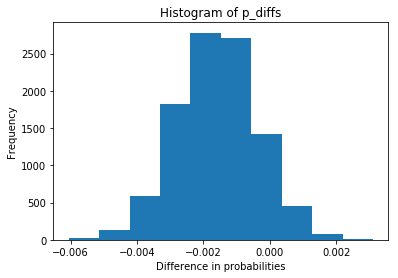

In [27]:
plt.hist(p_diffs)
plt.title('Histogram of p_diffs')
plt.xlabel('Difference in probabilities')
plt.ylabel('Frequency');

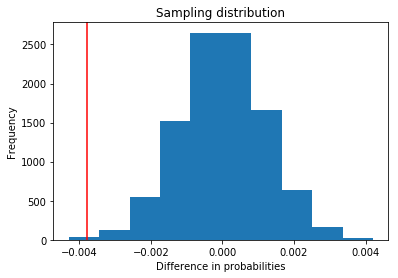

In [28]:
null_vals=np.random.normal(0, np.std(p_diffs), 10000)
plt.hist(null_vals)
plt.title('Sampling distribution')
plt.xlabel('Difference in probabilities')
plt.ylabel('Frequency')
plt.axvline(diff_orig, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
#Calculating the p-value
(null_vals > (p_new-p_old)).mean()

0.9097

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

__I calculated the p-value. If we have a p-value that is lower or equal to the type1 error rate of 5% we have defined above, we would have evidence to reject the null hypothesis in favor of the alternative. In our case we have a very large p-value that is much higher than our type1 error rate. Therefore we cannot reject the null hypothesis. We cannot tell that there is difference between the new and old pages regarding their conversion.__

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [31]:
from statsmodels.stats.proportion import proportions_ztest

In [32]:
#Performing a one-sided ztest with p0 being the old page and p1 being the new page, therefore choosing alternative=smaller as our H1 is p0<p1
stat, pval = proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
stat, pval

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

__They agree with the findings in parts j and k. The p-value is close to the one we have calculated above, also giving evidence that we cannot reject the null hypothesis. A low z-score supports this finding.__

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

__We should use a logistic regression as this is the type of regression used for predicting responses with only two possible outcomes, i.e. a categorical response.__

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2['intercept']=1
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [34]:
#Transforming landing_page into dummy variables and adding them as new columns to df2
df2[['ab_page', 'old_page']]=pd.get_dummies(df2['landing_page'])

In [35]:
#The obtained column old_page is obsolete as we have ab_page
df2=df2.drop('old_page', axis=1)

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
import statsmodels.api as sm

In [37]:
logm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        21:06:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

__The p-value associated with ab_page is 0.19. In part 2 we tried to determine the relationship between the layout of a page and the conversion of a user. Thereby the hypotheses were related to the probabilities of conversion of the two different layout types. For our logistic regression model we have tried to predict whether a user converts given a certain layout, the null hypothesis being that there is no relationship between the dependent and the independent variables.__ (source: http://www.biostathandbook.com/multiplelogistic.html).
__So in the Part II we have analyzed a one-tailed hypothesis test:__

$$H_0: p_{new} - p_{old} \leq 0 $$
$$H_1: p_{new} - p_{old} > 0 $$

__In Part III we have been analyzing a two-tailed hypothesis test where the null hypothesis states that a variable has no influence on the response variable (its coefficient being 0) and the alternative hypothesis stating that the coefficient is different from 0, thereby the independent variable having a significant influence on the dependent variable:__

$$H_0: \mu = 0 $$
$$H_1: \mu \neq 0 $$

__So in Part III we are looking at the p-value for the influence of a specific independent variable whereas in Part II we have been looking at the p-value of our test in general.__

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

__It depends on the factors and how they relate to the factors that are already present in the model. If we add new factors that are correlated to the ones already present (thereby increasing multicollinearity in the model) this will be a disadvantage. If the new factors add more useful context and thereby increase the explanatory power of the model, then this is a positive thing. So far we have not found statistical evidence that the page layout is related to the conversion of a user, therefore it makes sense to include more variables into the model to improve it.__

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [42]:
df_new=df_new.join(pd.get_dummies(df_new['country']))

In [43]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [44]:
logm_country=sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
result_country=logm_country.fit()
result_country.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 14 Jul 2019   Pseudo R-squ.:               2.323e-05
Time:                        21:33:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

__It does not look like country has an impact on conversion as for both CA and UK we receive high p-values.__

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [45]:
df_new['ab_page_CA']=df_new['ab_page']*df_new['CA']
df_new['ab_page_UK']=df_new['ab_page']*df_new['UK']

In [46]:
logm_interaction=sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'ab_page_CA', 'ab_page_UK']])
result_interaction=logm_interaction.fit()
result_interaction.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 14 Jul 2019   Pseudo R-squ.:               3.482e-05
Time:                        21:33:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

__The interaction terms also show high p-values and thereby no statistical evidence for being related to the conversion of a user.__

<a id='conclusions'></a>
## Conclusions

My analyses have shown that for the A/B we cannot reject the null hypothesis. Therefore we don't have evidence that the new layout will improve the conversion rate. When going further and trying to predict the conversion of a user given the layout and also country information, I could not find statistical support that those factors are related to the conversion of a user. Therefore it would make sense to take a look at other factors that might drive conversion, e.g. if a user has been a returning user or is a first time user of our webpage. Or the time a user spends on the page as an indicator of involvement with the page as involved users might convert more easily.